# 🌬️ Windfield Evolution Visualizer

Visualize how windfields evolve over time.

**Features:** Interactive slider, GIF export, custom parameters

## Setup

In [23]:
import sys, os, numpy as np, matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import interact, IntSlider
sys.path.append(os.path.abspath("../src"))
sys.path.append(os.path.abspath(".."))
from src.env_sailing import SailingEnv
from initial_windfields import get_initial_windfield, INITIAL_WINDFIELDS
print("Available:", sorted(INITIAL_WINDFIELDS.keys()))

Available: ['simple_static', 'static_headwind', 'training_1', 'training_2', 'training_3']


---
# Part 1: Windfield Configuration


## Choose Your Windfield


In [28]:
#############################################
### WINDFIELD CONFIGURATION #################
#############################################

# Option 1: Use existing windfield
USE_EXISTING = False  # Set to False to use custom parameters
WINDFIELD_NAME = "training_1"  # Choose from available windfields

# Option 2: Custom windfield parameters (only used if USE_EXISTING = False)
# Default values match training_1 configuration
CUSTOM_WIND_INIT = {
    'base_speed': 3.0,
    'base_direction': (-0.8, -0.2),  # NNW wind (North-Northwest)
    'pattern_scale': 32,
    'pattern_strength': 0.3,
    'strength_variation': 0.4,
    'noise': 0.1
}

CUSTOM_WIND_EVOL = {
    'wind_change_prob': 1.0,
    'pattern_scale': 128,
    'perturbation_angle_amplitude': 0.1,
    'perturbation_strength_amplitude': 0.0,
    'rotation_bias': 0.02,
    'bias_strength': 1.0
}

# Simulation parameters
SEED = 42
NUM_STEPS = 200

#############################################

if USE_EXISTING:
    print(f"Using: {WINDFIELD_NAME}")
else:
    print("Using custom windfield")
print(f"Seed: {SEED}, Steps: {NUM_STEPS}")


Using custom windfield
Seed: 42, Steps: 200


## Visualization Parameters


In [29]:
#############################################
### VISUALIZATION PARAMETERS ################
#############################################

# Arrow visualization
WIND_GRID_DENSITY = 32
WIND_ARROW_SCALE = 120

# Figure size
FIGURE_SIZE = (10, 10)

#############################################

print(f"Density: {WIND_GRID_DENSITY}x{WIND_GRID_DENSITY}")
print(f"Arrow scale: {WIND_ARROW_SCALE}")
print(f"Figure size: {FIGURE_SIZE}")


Density: 32x32
Arrow scale: 120
Figure size: (10, 10)


---
# Part 2: Generate Windfield Evolution


In [30]:
# Get windfield configuration
if USE_EXISTING:
    windfield_config = get_initial_windfield(WINDFIELD_NAME)
    wind_init_params = windfield_config['wind_init_params']
    wind_evol_params = windfield_config['wind_evol_params']
else:
    wind_init_params = CUSTOM_WIND_INIT
    wind_evol_params = CUSTOM_WIND_EVOL

# Create environment
env = SailingEnv(
    wind_init_params=wind_init_params,
    wind_evol_params=wind_evol_params,
    static_wind=False,
    wind_grid_density=WIND_GRID_DENSITY,
    wind_arrow_scale=WIND_ARROW_SCALE,
    render_mode="rgb_array"
)

env.seed(SEED)
env.reset(seed=SEED)

print(f"🌬️ Generating windfield evolution for {NUM_STEPS} steps...")

# Capture frames
frames = []
wind_fields = []

for step in range(NUM_STEPS):
    frame = env.render()
    frames.append(frame)
    wind_fields.append(env.wind_field.copy())
    env.step(8)  # Action 8 = stay in place
    if (step + 1) % 10 == 0:
        print(f"  Progress: {step + 1}/{NUM_STEPS}", end='\r')

print(f"\n✅ Generated {len(frames)} frames!")
print(f"Grid size: {env.grid_size}")
print(f"Avg wind speed: {np.mean([np.linalg.norm(wf) for wf in wind_fields]):.2f}")


🌬️ Generating windfield evolution for 200 steps...
  Progress: 200/200
✅ Generated 200 frames!
Grid size: (32, 32)
Avg wind speed: 96.02


---
# Part 3: Interactive Visualization


In [31]:
def show_frame(step):
    """Display a specific frame from the windfield evolution."""
    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(frames[step])
    plt.axis('off')
    if USE_EXISTING:
        title = f'{WINDFIELD_NAME} - Step {step}/{NUM_STEPS-1}'
    else:
        title = f'Custom Windfield - Step {step}/{NUM_STEPS-1}'
    plt.title(title, fontsize=14, pad=10)
    plt.tight_layout()
    plt.show()

# Create interactive slider
interact(
    show_frame,
    step=IntSlider(min=0, max=len(frames)-1, step=1, value=0, description='Step:')
)


interactive(children=(IntSlider(value=0, description='Step:', max=199), Output()), _dom_classes=('widget-inter…

<function __main__.show_frame(step)>

---
# Part 4: Wind Field Analysis

Analyze how the wind direction and strength change over time.


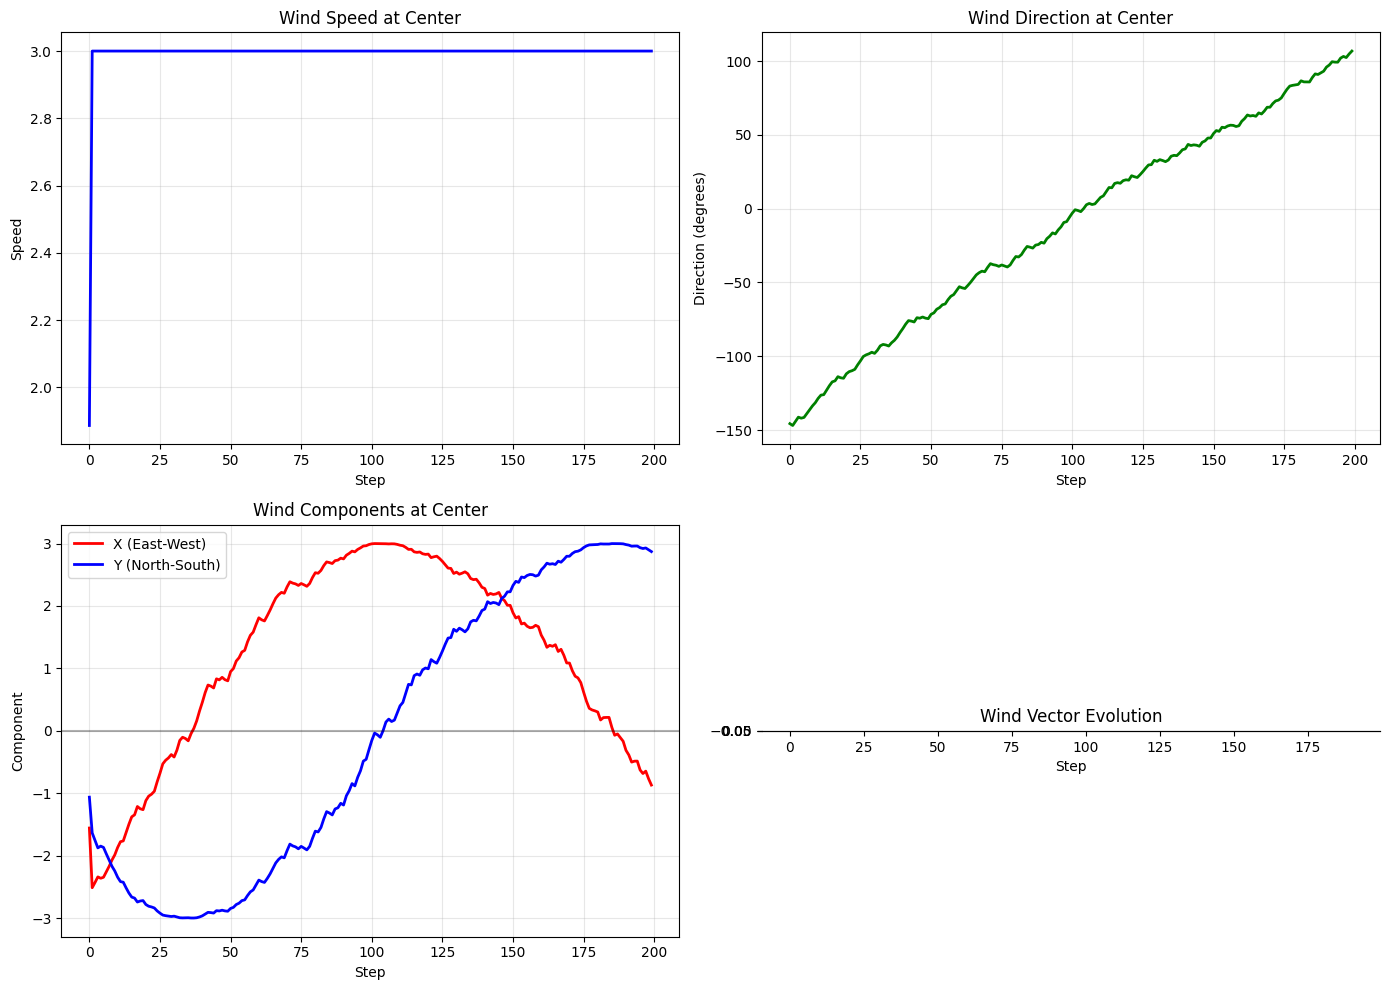

📊 Wind Statistics:
  Mean speed: 2.99
  Speed std dev: 0.08


In [32]:
# Analyze wind at center of grid
center_x, center_y = env.grid_size[0] // 2, env.grid_size[1] // 2
center_winds = [wf[center_y, center_x] for wf in wind_fields]

wind_x = [w[0] for w in center_winds]
wind_y = [w[1] for w in center_winds]
wind_speed = [np.linalg.norm(w) for w in center_winds]
wind_direction = [np.arctan2(w[1], w[0]) * 180 / np.pi for w in center_winds]

# Plot evolution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Wind speed
axes[0, 0].plot(wind_speed, linewidth=2, color='blue')
axes[0, 0].set_title('Wind Speed at Center')
axes[0, 0].set_xlabel('Step')
axes[0, 0].set_ylabel('Speed')
axes[0, 0].grid(True, alpha=0.3)

# Wind direction
axes[0, 1].plot(wind_direction, linewidth=2, color='green')
axes[0, 1].set_title('Wind Direction at Center')
axes[0, 1].set_xlabel('Step')
axes[0, 1].set_ylabel('Direction (degrees)')
axes[0, 1].grid(True, alpha=0.3)

# Wind components
axes[1, 0].plot(wind_x, linewidth=2, color='red', label='X (East-West)')
axes[1, 0].plot(wind_y, linewidth=2, color='blue', label='Y (North-South)')
axes[1, 0].set_title('Wind Components at Center')
axes[1, 0].set_xlabel('Step')
axes[1, 0].set_ylabel('Component')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0, color='k', linestyle='-', alpha=0.3)

# Wind vectors
sample_rate = max(1, NUM_STEPS // 20)
sampled_steps = range(0, NUM_STEPS, sample_rate)
sampled_x = [wind_x[i] for i in sampled_steps]
sampled_y = [wind_y[i] for i in sampled_steps]
axes[1, 1].quiver(sampled_steps, [0]*len(sampled_steps), sampled_x, sampled_y, angles='xy', scale_units='xy', scale=1, width=0.003)
axes[1, 1].set_title('Wind Vector Evolution')
axes[1, 1].set_xlabel('Step')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_aspect('equal')

plt.tight_layout()
plt.show()

print(f"📊 Wind Statistics:")
print(f"  Mean speed: {np.mean(wind_speed):.2f}")
print(f"  Speed std dev: {np.std(wind_speed):.2f}")


---
# Part 5: Create GIF Animation

Export the windfield evolution as an animated GIF.


In [33]:
#############################################
### GIF CONFIGURATION #######################
#############################################

CREATE_GIF = True  # Set to True to create a GIF

# GIF settings
if USE_EXISTING:
    GIF_OUTPUT_PATH = f"windfield_{WINDFIELD_NAME}_seed{SEED}.gif"
else:
    GIF_OUTPUT_PATH = f"windfield_custom_seed{SEED}.gif"

GIF_FPS = 20
GIF_STEP_INTERVAL = 1

#############################################

if CREATE_GIF:
    try:
        import imageio
        print(f"🎬 Creating GIF...")
        selected_frames = frames[::GIF_STEP_INTERVAL]
        imageio.mimsave(GIF_OUTPUT_PATH, selected_frames, fps=GIF_FPS, loop=0)
        print(f"✅ GIF created successfully!")
        print(f"   Saved to: {GIF_OUTPUT_PATH}")
        print(f"   Frames: {len(selected_frames)} | Duration: ~{len(selected_frames)/GIF_FPS:.1f}s")
    except ImportError:
        print("❌ Error: 'imageio' required. Install: pip install imageio")
else:
    print(f"ℹ️  GIF creation disabled. Set CREATE_GIF = True to enable.")
    print(f"   Would save to: {GIF_OUTPUT_PATH}")


🎬 Creating GIF...
✅ GIF created successfully!
   Saved to: windfield_custom_seed42.gif
   Frames: 200 | Duration: ~10.0s


---
# Tips & Information

## Windfield Parameters:

**Initialization:**
- `base_speed`: Base wind speed (3-5)
- `base_direction`: Direction as (x, y) vector
- `pattern_scale`: Spatial scale (larger = smoother)
- `pattern_strength`: Spatial variation (0-1)
- `noise`: Random noise level (0-1)

**Evolution:**
- `wind_change_prob`: Update probability per step (0-1)
- `perturbation_angle_amplitude`: Direction change per step
- `rotation_bias`: Rotational tendency (positive = clockwise)

## Visualization:
- Lower `WIND_GRID_DENSITY` = fewer arrows
- Higher `WIND_ARROW_SCALE` = shorter arrows
- Use slider to see step-by-step evolution
- Watch for rotational patterns and wind shifts

## Default Execution:
Running all cells visualizes `training_1` windfield for 100 steps with interactive slider and wind analysis charts.
